# Joint probability experiment

In [1]:
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=7, repr.plot.height=5)

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./cpp/coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

In [10]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=7, repr.plot.height=5)

# ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

## Section from Tobias paper that was taken out

We note that, although computationally infeasible in most situations, the joint distribution function of multivariate discrete phase-type distributions can also be described by such a recursive algorithm (and time-inhomogeneous multivariate discrete phase-type distributions as seen later). Instead of defining the probability of the system visiting a vertex at time $t$, we instead keep track of both the visited vertex and the accumulated reward at time $t$. Consider an $\ell+1$-dimensional table for an $\ell$-dimensional multivariate discrete phase-type distribution. The first dimension has $|V|$ entries, one for each vertex. The other dimensions has entries corresponding to the natural numbers from $0$ to $k$ where $k$ is sufficiently large, such that for a given distribution function of specified accumulated rewards $\vec{s}$, $F_{\vec{s}}$, then $k$ is larger or equal to any entry in $\vec{s}$. At a time $t$ an entry in the table corresponds to the probability of the system being in a specific state, and having accumulated a specific vector of integer rewards corresponding to the other dimensions. If we have accumulated more than any of the rewards $\vec{s}$, we assign probability zero to the entry in the table before the next time step. Assuming we have removed the vertices with zero rewards in all dimensions (e.g. using the reward transformation algorithm), then all time steps will increase at least one entry in the reward accumulation, and after a finite number of steps all entries will either be zero, or for the absorbing vertices the total probability of the system having reached an absorbing state with less than or equal to the rewards $\vec{s}$, which is the definition of the cumulative distribution function for the multivariate discrete phase-type distribution.

## Generate standard coalescent state space

If you want to generate the state space:

In [11]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n + 1    ## + 1 needed to keep it from dumping ##################
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

In [12]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# # self-transition rate:
# mutation_rate <- 1e-8

# # clone graph to get one to modify:
# mutation_graph <- clone_graph(graph)

# # add auxilliary states, normalize and return reward matrix:
# rewards <- make_discrete(mutation_graph, mutation_rate)

# # for plotting the new graph
# gam <- graph_as_matrix(mutation_graph)

## State space for joint proability computation

Generate coalescent state space like normal with the following modifications

- Change state space from (4, 0, 0, 0) to (4, 0, 0, 0, t1, t2, t3, t4). The last extra "ton" states keep track of the number accumulated mutations of each kind. We simply double the state vector so we keep track of the counts lineages with descendants, but also the counts of mutations happened on such lineages.
- Each state can mutate to accumulate a "ton" in accordance with its state vector. E.g., a `(4, 0, 0, 0, 0, 0, 0, 0)` state can only make singletons,  a `(2, 1, 0, 0, 0, 0, 0, 0)` state can only make singletons and doubletons.
- A mutation event is a transition to a siter state E.g., `(4, 0, 0, 0, 0, 0, 0, 0) -> (4, 0, 0, 0, 1, 0, 0, 0)`
- The ton counts have a maximum value (base-1). If this value is reached, the mutation transition instead leads to a trash state with an infinite self loop. The transitions to trash represents the part of the deficient PDF not covered because we only run up to a max nr of tons.

## Reward transform

- Convert the last half of each state (with ton counts) to numbers in some base.
- Use these for reward transformation.
- Compute PDF for t <- 1:sample_size^(base-1)
- Convert each time t back to the corresponding ton vector and associate it with the probability
- group by two tons and sum probs in groups to get all pairwise combinations for a joint probability matrix.

## Figure out why you get NAs in multi_rewards with max_tons <- 1

In [13]:
# joint_prob_coalescent <- function(n, mutation_rate, max_tons, total_tons=Inf) {
    
#     state_vector_length <- n + n + 1
#     graph <- create_graph(state_vector_length)
#     starting_vertex <- vertex_at(graph, 1)
#     initial_state <- c(rep(0, n), 0)
#     initial_state[1] <- n
    
#     add_edge(
#       starting_vertex,
#       create_vertex(graph, initial_state),
#       1
#     )
#     index <- 2

#     while (index <= vertices_length(graph)) {
#       vertex <- vertex_at(graph, index)

#       # skip if we only have one lineage left or if this is a trash state
#       if (sum(vertex$state[1:n]) <= 1) {
#         index <- index + 1
#         next
#       }

#       # mutations
#       trash_rate <- 0 
#       for (i in 1:n)  {
#         state <- vertex$state          
#         rate <- vertex$state[i] * mutation_rate
#         nr_tons <- state[n+i]
#         if (rate > 0) {
#             if (nr_tons < max_tons && sum(vertex$state[(n+1):(2*n)]) < total_tons) {
#               child_state <- state

#               mutation_vertex <- create_vertex(graph, rep(0, state_vector_length))
#               add_edge(vertex, mutation_vertex, rate)
#               child_state[n+i] <- child_state[i+n] + 1
#               add_edge(mutation_vertex, find_or_create_vertex(graph, child_state), 1)
                
#               # child_state[n+i] <- child_state[i+n] + 1
#               # add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
#             } else {
#               trash_rate <- trash_rate + rate
#             }
#         }          
#       }
#       if (trash_rate > 0) {
#         add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
#       }

#       # loop over all classes of lineages
#       for (i in 1:n) {
#         for (j in i:n) {
#           state <- vertex$state
          
#           # if same class, there need to be at least two to coalesce
#           if (i == j) {
#             if (state[i] < 2) {
#               next;
#             }
#             # coal rate
#             rate <- state[i] * (state[i] - 1) / 2
#           } else {
#             # else at least one in each class to coalesce
#             if (state[i] < 1 || state[j] < 1) {
#               next;
#             }
#             # number of combinations
#             rate <- state[i] * state[j]
#           }
          
#           # copy state
#           child_state <- state
#           # update child state
#           child_state[i] <- child_state[i] - 1
#           child_state[j] <- child_state[j] - 1
#           child_state[i+j] <- child_state[i+j] + 1

#           add_edge(
#               vertex,
#               find_or_create_vertex(graph, child_state),
#               rate
#             )
#         }
#       }

#       index <- index + 1
#     }
#     trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
#     trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
#     add_edge(trash_vertex, trash_loop_vertex, 1)
#     add_edge(trash_loop_vertex, trash_vertex, 1)
    
#     return(graph)
# }
# # states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# # ipv <- graph_as_matrix(graph)$IPV
# # sim <- graph_as_matrix(graph)$SIM

# # sample_size <- 4
# # # mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
# # mutation_rate <- 1
# # max_tons <- 3
# # base <- max_tons + 1
# # # graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons)
# # # gam <- graph_as_matrix(graph)
# # # #gam

# # graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons)
# # gam <- graph_as_matrix(graph)
# # plot_graph(gam, #subgraphs=TRUE, 
# #            rainbow=TRUE,
# #            size=c(10, 8), 
# #            align=TRUE,
# #            fontsize=16, ranksep=1, nodesep=0.25,          
# #            # subgraphfun=function(state) paste(state[-length(state)], collapse="")
# #            )

In [14]:

joint_prob_coalescent <- function(n, mutation_rate, max_tons, total_tons=Inf) {

    stopifnot(total_tons == Inf)
    
    state_vector_length <- n + n + 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(rep(0, n), 0)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

      # skip if we only have one lineage left or if this is a trash state
      if (sum(vertex$state[1:n]) <= 1) {
        index <- index + 1
        next
      }
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate
            )
        }
      }

      # mutations
      trash_rate <- 0 
      for (i in 1:n)  {
        rate <- vertex$state[i] * mutation_rate
        nr_tons <- child_state[n+i]
        if (rate > 0) {
            if (nr_tons < max_tons && sum(vertex$state[(n+1):(2*n)]) < total_tons) {
              child_state <- state
              child_state[n+i] <- child_state[i+n] + 1
              add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
            } else {
              trash_rate <- trash_rate + rate
            }
        }
      }
      if (trash_rate > 0) {
        add_edge(vertex, find_or_create_vertex(graph, rep(0, state_vector_length)), trash_rate)
      }

      index <- index + 1
    }
    trash_vertex <- find_or_create_vertex(graph, rep(0, state_vector_length))
    trash_loop_vertex <- create_vertex(graph, rep(0, state_vector_length))
    add_edge(trash_vertex, trash_loop_vertex, 1)
    add_edge(trash_loop_vertex, trash_vertex, 1)
    
    return(graph)
}

# Tobias method

In [233]:
joint_probabilities <- function(graph, reward_limits, mutation_rate, tot_reward_limit=Inf, return_graph=FALSE) {

    #reward_limits <- c(1, 1)
    # reward_limits <- rep(1, sample_size-1)
    reward_dims <- length(reward_limits)

    # get all possible reward combinations respecting the reward_limits
    possible_rewards <- as.list(as.data.frame(t(
        expand.grid(
            sapply(reward_limits, function(x) list(0:x))
                   ) 
                )))

    # remove reward combinations not respecting the tot_reward_limit                                
    possible_rewards <- possible_rewards[sapply(possible_rewards, function(x) sum(x)<=tot_reward_limit)]
                                
    # m <- matrix(0, nrow = reward_dims, ncol = reward_dims)
    # diag(m) <- 1
    # possible_rewards <- as.list(as.data.frame(m))
                                
    m <- matrix(0, nrow = reward_dims, ncol = reward_dims)
    diag(m) <- 1
    reward_increments <- as.list(as.data.frame(m))
    
    #Position(function(x) identical(x, state), possible_rewards, nomatch = 0) > 0
    
    # new graph
    state_vector_length <- length(vertex_at(graph, 1)$state) + reward_dims
    state_reward_indices <- (state_vector_length-reward_dims+1):state_vector_length
    new_graph <- create_graph(state_vector_length)
    
    # add vertices to new graph
    t_vertex_indices <- c()
    for (vertex in vertices(graph)) {
        for (p in possible_rewards) {
          state <- c(vertex$state, p)
          new_vertex <- find_or_create_vertex(new_graph, state) # if I use create_vertex here, I cannot find it again with find_vertex...
          if (length(edges(vertex)) == 0) {
            t_vertex_indices <- c(t_vertex_indices, new_vertex$index) 
          }
        }
    }
    # trash states
    trash_vertex <- find_or_create_vertex(new_graph, rep(0, state_vector_length))
    trash_loop_vertex <- create_vertex(new_graph, rep(0, state_vector_length))
    add_edge(trash_vertex, trash_loop_vertex, 1)
    add_edge(trash_loop_vertex, trash_vertex, 1)
    
    # add edges to new graph
    for (vertex in vertices(graph)) {
    
        if (vertex$index == 1)
            next
        
        state <- vertex$state
        for (p in possible_rewards) {
            new_vertex <- find_vertex(new_graph, c(state, p))
            for (edge in edges(vertex)) {            
                child_state <- edge$child$state
                add_edge(new_vertex, 
                         find_vertex(new_graph, c(child_state, p)), 
                         edge$weight)
            }
            new_vertex_rewards <- tail(new_vertex$state, reward_dims)
    
            trash_rate <- 0
            # for (r in reward_increments) {
            for (i in 1:reward_dims) {
                r <- rep(0, reward_dims)
                r[i] <- 1
                
                # if (list(new_vertex_rewards + r) %in% possible_rewards) {                 
                rate <- state[i] * mutation_rate 
                
                if ( all(new_vertex_rewards + r <= reward_limits) & sum(new_vertex_rewards + r) <= tot_reward_limit) {
                    add_edge(new_vertex,
                             find_vertex(new_graph, c(state, new_vertex_rewards + r)), 
                             rate)
                } else {
                    trash_rate <- trash_rate + rate
                }
            }
            add_edge(new_vertex, trash_vertex, trash_rate)
    
            
        }
    
    }
    # add edges from t-states to new final absorbing
    new_absorbing <- create_vertex(new_graph, rep(0, state_vector_length))
    for (i in t_vertex_indices) {
        add_edge(vertex_at(new_graph, i), new_absorbing, 1)
    }
    
    # add edges from starting vertex (IPV)
    starting_vertex <- vertex_at(graph, 1)
    new_starting_vertex <- vertex_at(new_graph, 1)
    for (edge in edges(starting_vertex)) {
        add_edge(new_starting_vertex, find_vertex(new_graph, c(edge$child$state, rep(0, reward_dims))), 1)
    }
    
    # normalize graph                            
    weights_were_multiplied_with <- normalize_graph(new_graph)

    if (return_graph)                           
        return(new_graph)
    
    # time spent in each of the the t-states after some appropriately large time (these are the joint probs)
    # (maybe I can somehow figure out to stop at the 0.999 quantile)
    start <- proc.time()[3]
    accum_time <- accumulated_visiting_time(new_graph, 100)[t_vertex_indices]
    proc.time()[3] - start
    
    # data frame with joint probs
    states <- states(new_graph)
    state_reward_matrix <- as.data.frame(states[t_vertex_indices, state_reward_indices])
    #data[cols] <- lapply(data[cols], factor)  ## as.factor() could also be used

    print(c(vertices_length(graph), vertices_length(new_graph)))
                                
    joint_probs <- cbind(state_reward_matrix, accum_time)
    return(joint_probs)   

}  

In [242]:
sample_size <- 20
graph <- standard_coalescent(sample_size)
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, # rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25)

In [ ]:
                                
# reward_limits <- rep(20, sample_size-1)
reward_limits <- rep(1, sample_size-1)
tot_reward_limit <- 2
                                                
stopifnot(length(reward_limits) == sample_size-1)
                                                
# mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
mutation_rate <- 1

start <- proc.time()[3]
joint_probs <- joint_probabilities(graph, reward_limits, mutation_rate, tot_reward_limit=tot_reward_limit)
proc.time()[3] - start

if (vertices_length(new_graph) < 30) {
    new_graph <- joint_probabilities(graph, reward_limits, mutation_rate, tot_reward_limit=tot_reward_limit, return_graph=TRUE)
    plot_graph(graph_as_matrix(new_graph), size=c(10, 10), align=TRUE, rainbow=TRUE,
                   fontsize=16, ranksep=2, nodesep=0.5,
              subgraphs=TRUE,         
               subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))  
}               
                                                
head(joint_probs)                                

In [221]:
c(sum(joint_probs$V1 * joint_probs$accum_time), 
  sum(joint_probs$V2 * joint_probs$accum_time), 
  sum(joint_probs$V3 * joint_probs$accum_time))

[1] 1.9998174 0.9981528 0.6666384

In [230]:
joint_probs %>% filter(V1==1, V2==0, V3==1) 

V1,V2,V3,accum_time
<int>,<int>,<int>,<dbl>
1,0,1,0.03111111


With `mutation_rate <- 1` and `reward_limits <- rep(20, sample_size-1)`, the marginal probabilities match the SFS:

```
c(sum(joint_probs$V1 * joint_probs$accum_time), 
  sum(joint_probs$V2 * joint_probs$accum_time), 
  sum(joint_probs$V3 * joint_probs$accum_time))
```

```
1.999817437595780.9981527713958280.666638375487117
```

and the joint prob of a singleton and a trippleton is:

```
1	0	1	0.03111111
```

which is exactly what we also get with `reward_limits <- rep(1, sample_size-1)`.

Setting `tot_reward_limit <- 2` also produces `0.03111111`.

In [222]:
if (vertices_length(new_graph) < 30) {
    new_graph <- joint_probabilities(graph, reward_limits, mutation_rate, 
                                       # tot_reward_limit=2
                                       return_graph=TRUE
                                      )
    plot_graph(graph_as_matrix(new_graph), size=c(10, 10), align=TRUE, rainbow=TRUE,
                   fontsize=16, ranksep=2, nodesep=0.5,
              subgraphs=TRUE,         
               subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))  
}           

`summarise()` has grouped output by 'V1'. You can override using the `.groups` argument.


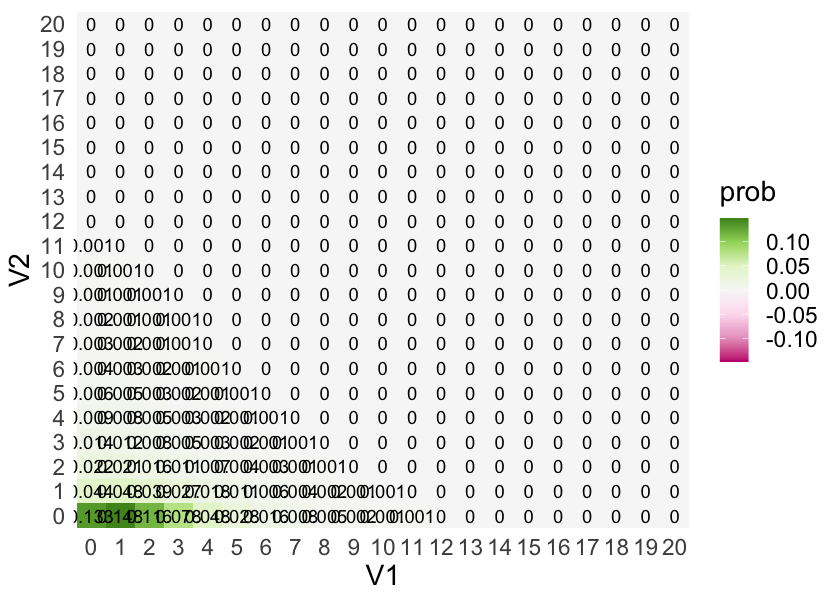

In [228]:
plot_df <- joint_probs %>% group_by(V1, V2) %>% summarize(prob=sum(accum_time))

for (colname in colnames(plot_df)) {
    if (startsWith(colname, 'V')) {
        plot_df[[colname]] <- as.factor(plot_df[[colname]])
    }
}

ggplot(plot_df, aes(x=V1, y=V2)) +
    geom_tile(aes(fill = prob)) + 
    geom_text(aes(label = round(prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

## base-n approach

In [150]:
ndigits <- function(x){
  y <- floor(abs(x))
  if(y != 0){
    floor(log10(y)) + 1
  } else {
    1
  }
}
rev_number=function(n){
    m=as.integer(rev(strsplit(as.character(n),"")))
    if (m==rev(m)) print("reversed number")
}
forth <- function(vec, base) {
    # return( as.integer( c(vec %*%  (base ^ rev(seq_along(vec)) / base)) ) )
    # return( as.integer( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) )
    # return( c(vec %*%  (base ^ (rev(seq_along(vec))) / base)) ) 
    return( c(vec %*%  (base ^ (seq_along(vec)) / base)) ) 
}
back <- function(x, base, state_length) {
    # x <- as.integer(rev(paste(x, collapse='')))
    # x <- floor(as.numeric(rev(paste(x, collapse=''))))
    vec <- c()

    for (i in 1:state_length) {
        # if (x > 0) {
            vec <- c(x %% (base), vec)
            x <- x %/% (base)
        # }
    }

    # while (x > 0) {
    #     vec <- c(x %% (base), vec)
    #     x <- x %/% (base)
    # }
    
    # for (i in 1:ndigits(x)) {
    #     if (x > 0) {
    #         vec <- c(x %% (base), vec)
    #         x <- x %/% (base)
    #     }
    # }
    vec <- as.integer(vec)
    return( rev(c(rep(0, state_length-length(vec)), vec) ))
    # return( c(rep(0, state_length-length(vec)), vec) )
}
# vec <- c(1, 2, 0)
# base <- max(vec)+1
# state_length <- length(vec)
# print(vec)
# f <- forth(vec, base)
# print(f)
# b <- back(f, base, state_length)
# print(b)
# b <- c(rep(0, length(vec)-length(b)), b)
# print(b)

In [151]:
graph <- standard_coalescent(sample_size)
graph_as_matrix(graph)

$states
     [,1] [,2] [,3] [,4]
[1,]    3    0    0    0
[2,]    1    1    0    0

$SIM
     [,1] [,2]
[1,]   -3    3
[2,]    0   -1

$IPV
[1] 1 0

$indices
[1] 2 3

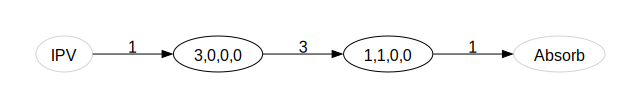

In [152]:
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, # rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25)

In [153]:
expectation(graph)

[1] 1.333333

In [154]:
rewards <- make_discrete(graph, 1)
graph_as_matrix(graph)

$states
     [,1] [,2] [,3] [,4]
[1,]    0    0    0    0
[2,]    3    0    0    0
[3,]    0    0    0    0
[4,]    0    0    0    0
[5,]    1    1    0    0

$SIM
     [,1] [,2]       [,3]       [,4] [,5]
[1,] -1.0    1  0.0000000  0.0000000  0.0
[2,]  0.5   -1  0.0000000  0.0000000  0.5
[3,]  0.0    0 -1.0000000  0.0000000  1.0
[4,]  0.0    0  0.0000000 -1.0000000  1.0
[5,]  0.0    0  0.3333333  0.3333333 -1.0

$IPV
[1] 0 1 0 0 0

$indices
[1] 5 2 7 6 3

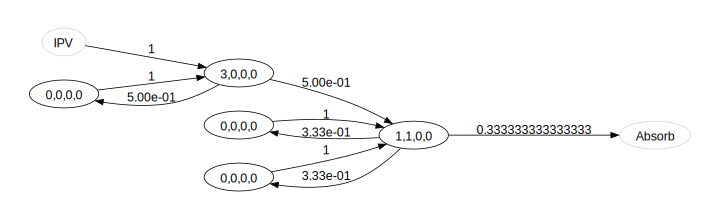

In [155]:
plot_graph(graph_as_matrix(graph), #rainbow=TRUE, 
           size=c(10, 8), #align=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
             # subgraph=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
)

In [156]:
apply(rewards[1:3,], 1, function(x) expectation(graph, x))

[1] 2 1 0

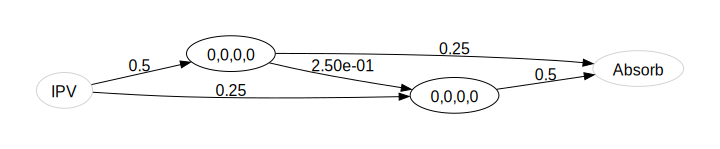

In [157]:
rev_graph <- reward_transform(graph, rewards[1,])
plot_graph(graph_as_matrix(rev_graph), #rainbow=TRUE, 
           size=c(10, 8), #align=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
             # subgraph=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
)

In [158]:
pdph(1:10, rev_graph)

[1] 0.5000000 0.6875000 0.8125000 0.8906250 0.9375000 0.9648438 0.9804688
 [8] 0.9892578 0.9941406 0.9968262

# Compute joint prob

> **Constraining the total number of mutations does not work**
> 
> The deficit is computed correctly as long as all max rewards so that all r scalar values in the CDF represents a reward combination in the MDF
> 
> Just like we can limit the number of each king of tons in the state space contruction, we might also limit the total number of mutations so that we, for example, can have at most one instance of two different tons (`total_tons=2`). E.g., a singleton and a tripleton.
> 
> However, this gives a a deficit problem I am not sure I can solve with this approach. In principle, the deficit should be taken care of, and I should just discard all joint probs for total numbers of tons larger than `total_tons` - but that does not seem to be the case...

**maybe I don't need loops if they are not selff-loops anyway. If aux->C has rate 1 then A->aux->C is the same as A->C. Below I just changed two things**

1. normalize the graph
2. use pdph instead of pph

**BUT** if I normalize I need to represent the residual prob as reward, which means I need to reward transform, which I cannot if I want to do everying in one go with the scalar trick. 

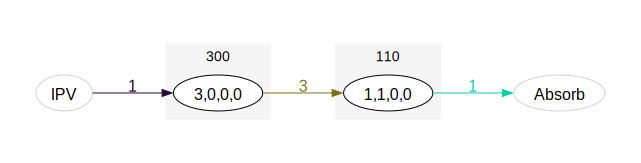

In [159]:
#sample_size <- 3

graph <- standard_coalescent(sample_size)
plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=1, nodesep=0.25,
            subgraphs=TRUE,         
           subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))

In [160]:
# mutation_rate <- 20000 * 31 * 5e-10 # 0.00031
mutation_rate <- 1
max_tons <- 1
total_tons <- Inf
base <- max_tons + 1
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons=total_tons)

weights_were_multiplied_with <- normalize_graph(graph)

# gam <- graph_as_matrix(graph)
#gam

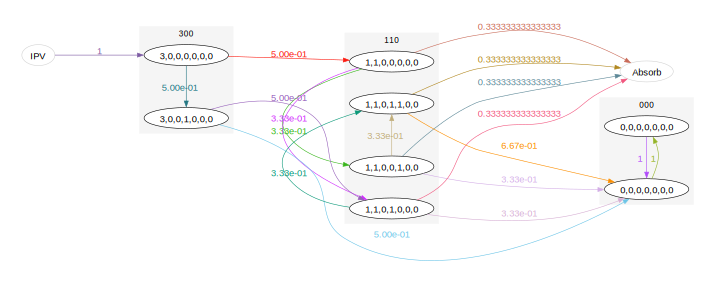

In [161]:
if (vertices_length(graph) < 50)
    plot_graph(graph_as_matrix(graph), size=c(10, 8), align=TRUE, rainbow=TRUE,
               fontsize=16, ranksep=2, nodesep=0.5,
             subgraphs=TRUE,         
           subgraphfun=function(state, index) paste(state[1:sample_size], collapse=""))

Get last halves of states that server as mutation rewards:

In [162]:
rewards <- states(graph)[, (sample_size+1):(2*sample_size)]

Turn reward vectors into scalars (with the appropriate base):

In [163]:
multi_rewards <- apply(rewards, 1, forth, base=base)
multi_rewards

[1] 0 0 0 1 0 1 2 0 1 3 2 3 0

Loop over states except starting to find trash vertices and give them a reward so they won't dissapear in the reward transformation. They will not contribute this reward because they are dead ends:

In [164]:
trash_states <- c()
for (i in 2:vertices_length(graph)) {
  vertex <- vertex_at(graph, i)
  if (sum(vertex$state) == 0) {
    multi_rewards[i] <- 1
    trash_states <- c(trash_states, i)
  }
}
trash_states

[1]  8 13

In [165]:
multi_rewards

[1] 0 0 0 1 0 1 2 1 1 3 2 3 1

Reward transform graph using scalar rewards:

In [166]:
rew_graph <- reward_transform(graph, multi_rewards)

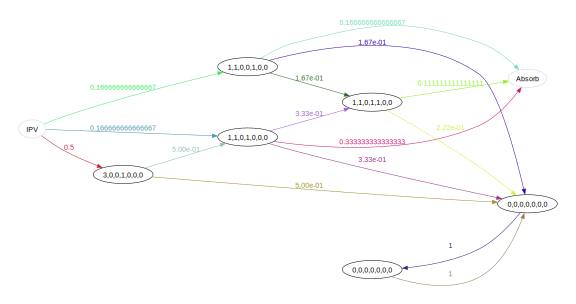

In [167]:
if (vertices_length(graph) < 50)
    plot_graph(graph_as_matrix(rew_graph),
           rainbow=TRUE,
           size=c(8, 8), 
           align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5, 
           # subgraphs=TRUE, subgraphfun=function(state, index) as.character((index+1) %/% 2)
           )

Compute CDF assming no mutation count exceeds `max_tons`:

In [168]:
cdf_df <- data.frame(t=seq(0, base^(sample_size-1) - 1, 1))
cdf_df['cdf'] <- sapply(cdf_df$t, function (t) pdph(t, rew_graph))
# cdf_df['cdf'] <- sapply(cdf_df$t, function (t) pph(t, rew_graph))
tail(cdf_df)

,t,cdf
,<dbl>,<dbl>
1,0,0.1666667
2,1,0.2500000
3,2,0.3564815
4,3,0.3804012


Convert reward scalars back into state vectors representing ton counts:

In [169]:
x <- lapply(cdf_df$t, back, base=base, state_length=sample_size)
m <- do.call(rbind, x)

In [170]:
# is_additional_deficit <- as.integer(rowSums(m) > total_tons)
# p <- df$cdf
# pdf_from_cdf <- c(p[1], p[2:length(p)] - p[-length(p)])
# additional_deficit <- cumsum(pdf_from_cdf * is_additional_deficit)
# additional_deficit

In [171]:
df <- cbind(cdf_df, data.frame(m))
tail(df)

,t,cdf,X1,X2,X3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.1666667,0,0,0
2,1,0.2500000,1,0,0
3,2,0.3564815,0,1,0
4,3,0.3804012,1,1,0


The deficit is taken care of, so you should discard all joint probs for total numbers of tons larger than `total_tons`:

In [172]:
# df <- df[!is_additional_deficit, ]
# df

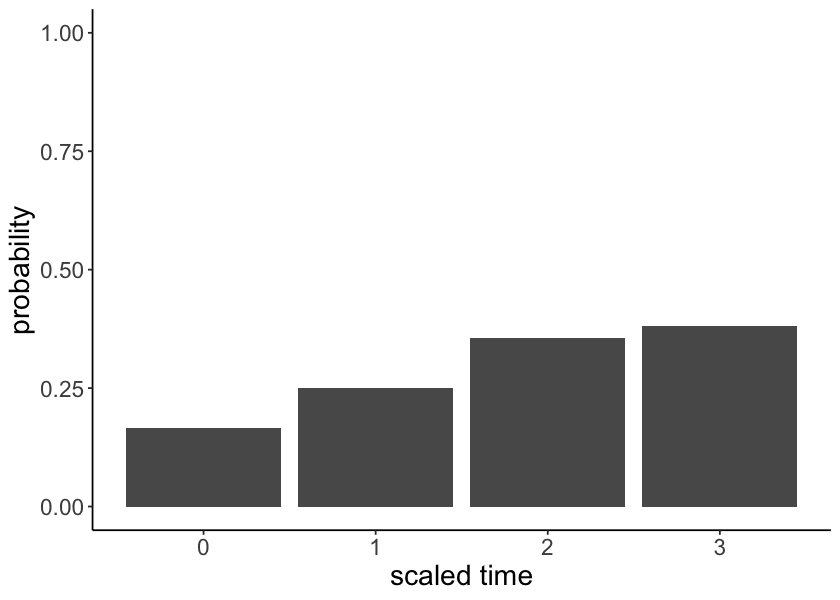

In [173]:
df %>% ggplot(aes(x=t, y=cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Compute probability of standing in on of the trash states for each time t in our CDF. These represent the deficit of the computed CDF:

> Make sure the stop_probability is the discrete version of that is what we are doing

In [174]:
trash_prob <- c()
for (t in df$t) {
    # s <- stop_probability(graph, t)
    s <- dph_stop_probability(graph, t)
    trash_prob <- c(trash_prob, sum(s[trash_states]))
}
df['cdf_deficit'] <- trash_prob
head(df)

,t,cdf,X1,X2,X3,cdf_deficit
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.1666667,0,0,0,0.0000000
2,1,0.2500000,1,0,0,0.0000000
3,2,0.3564815,0,1,0,0.2500000
4,3,0.3804012,1,1,0,0.4444444


CDF deficit:

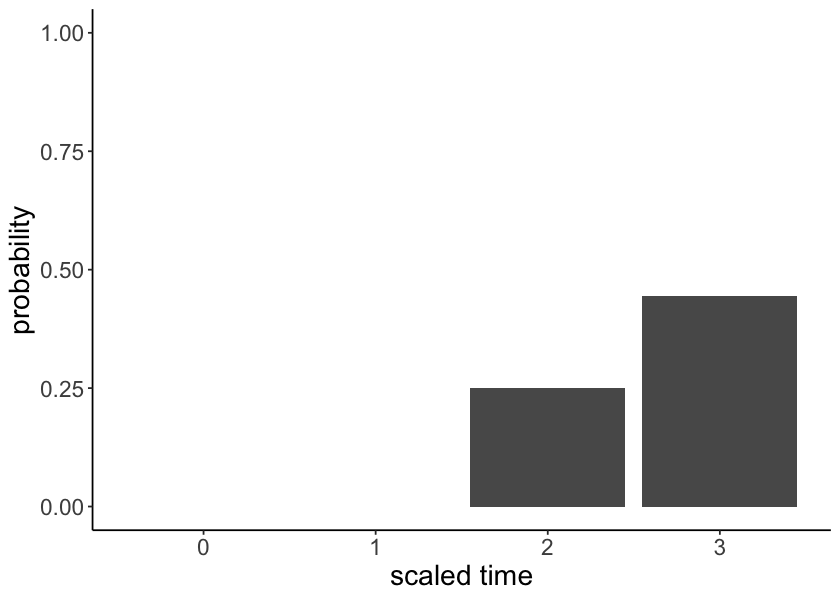

In [175]:
df %>% ggplot(aes(x=t, y=cdf_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + ylim(0, 1)

Sanity check: adding CDF and deficit should produce a CDF that goes to 1:

In [176]:
df['cdf_incl_deficit'] <- df$cdf + df$cdf_deficit

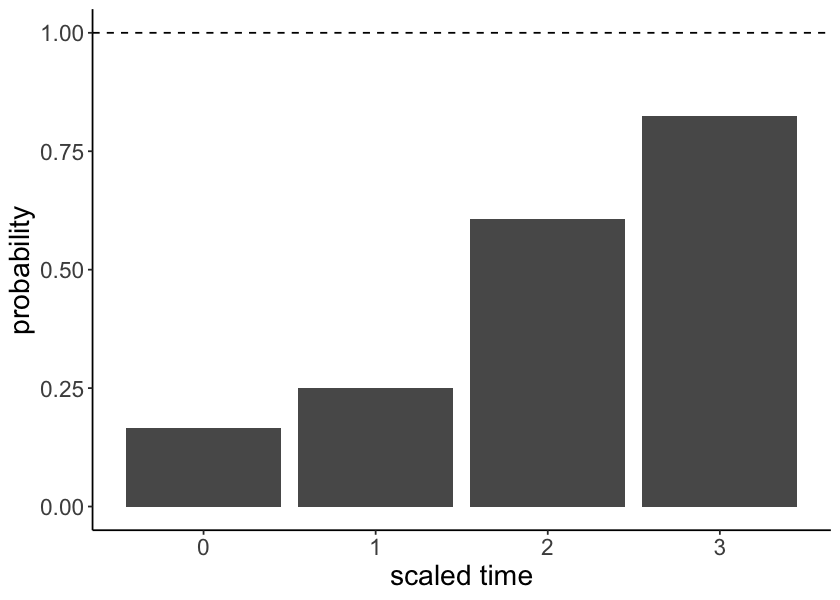

In [177]:
df %>% ggplot(aes(x=t, y=cdf_incl_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine + 
    ylim(0, 1) + 
    geom_hline(yintercept=1, linetype="dashed")

I.e., and a PDF that sum to one:

In [178]:
p <- df$cdf_incl_deficit
df['pdf_from_cdf_incl_deficit'] <- c(p[1], p[2:length(p)] - p[-length(p)])

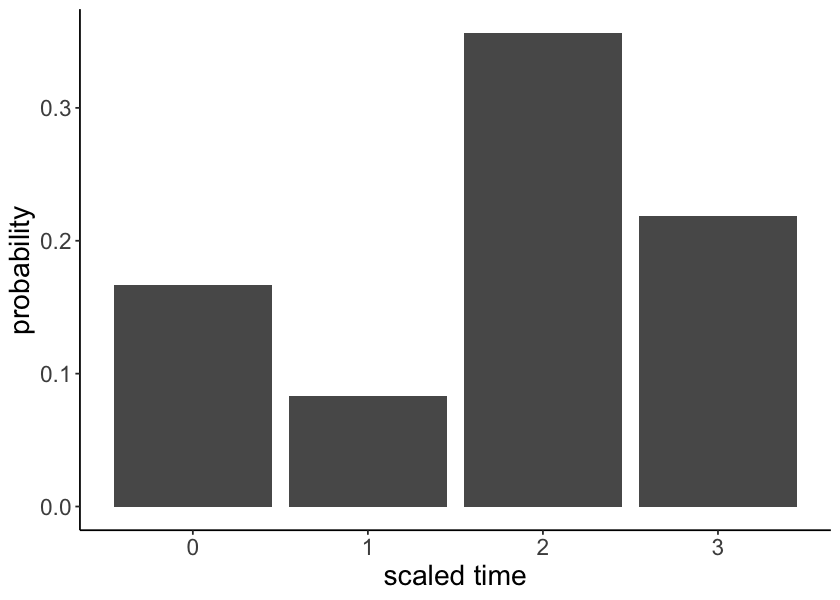

In [179]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf_incl_deficit)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

In [180]:
sum(df$pdf_from_cdf_incl_deficit)

[1] 0.8248457

It **almost** does... Maybe a numerical issue

Compute PDF from the CDF (**this is the one we are after**):

In [181]:
p <- df$cdf
df['pdf_from_cdf'] <- c(p[1], p[2:length(p)] - p[-length(p)])
df['prob'] = df$pdf_from_cdf

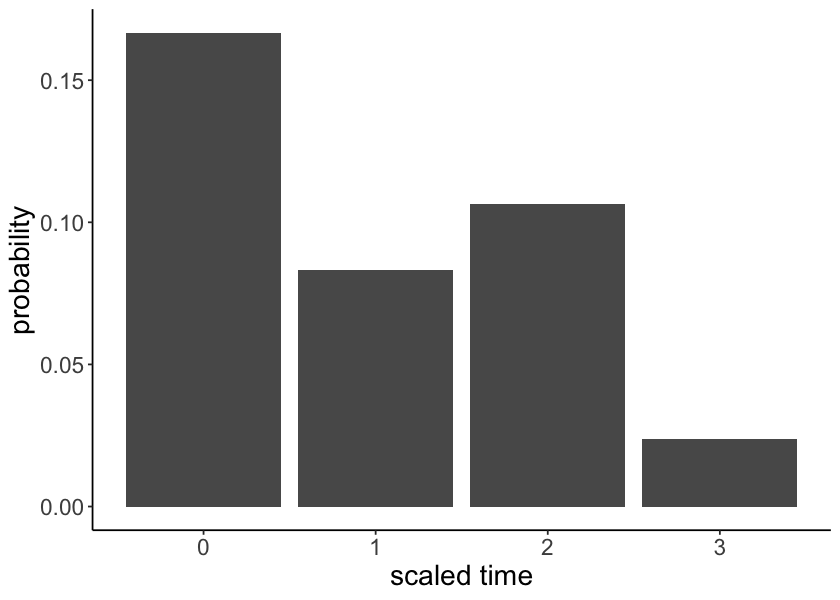

In [182]:
df %>% ggplot(aes(x=t, y=pdf_from_cdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine

The reason we need to go through the CDF to get the PDF is that the PDF function in PtD computes the distribution of times when the absorbing state is reached. It this cannot take the deficit in trash_states into account. The PDF commputed directly looks like this:

> Make sure I ues the discrete version here if I also use the dicscrete CDF above

In [183]:
# df['pdf'] <- sapply(df$t, function (t) dph(t, rew_graph))
df['pdf'] <- sapply(df$t, function (t) ddph(t, rew_graph))

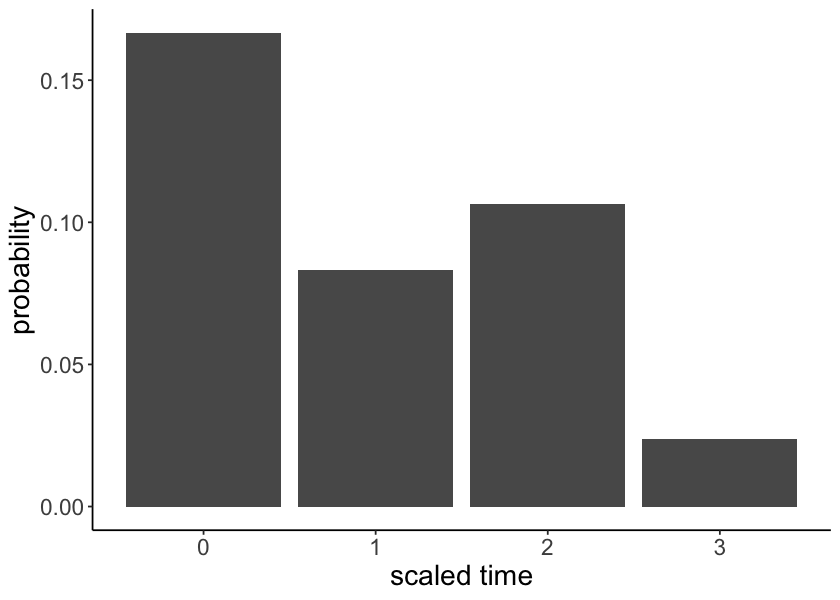

In [184]:
df %>% ggplot(aes(x=t, y=pdf)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine 

# When we do the discrete version, we don't need to go through the CDF to get the PDF. We can just use the `ddph` directly

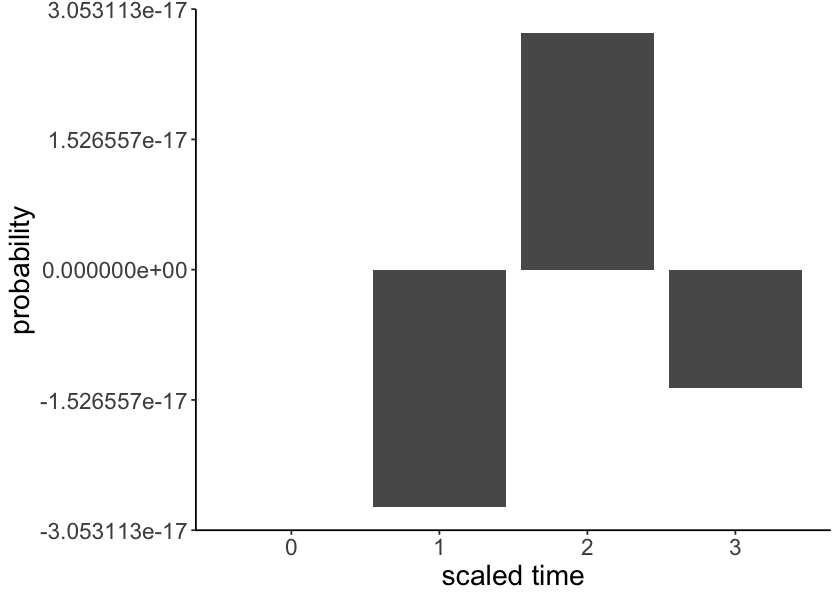

In [185]:
df['diff'] <- df['pdf_from_cdf'] - df['pdf']
df %>% ggplot(aes(x=t, y=diff)) + 
    geom_bar(stat="identity") +
    labs(x='scaled time', y='probability') + 
    despine 


The marginal expectations does not match the SFS proportions, because paths that accumulate more than `max_tons` singletons will end in the trash state and not have the opportunity to also accumulate doubletons etc. That reflects that the the joint prob of a singleton *and* a doubleton is be a subset of the singleton probability. That way the total marginal singleton prob will be roughly sfs expectation, but the total marginal doubleton prob will be much too small:

In [186]:
sfs <- c(1, 1/2, 1/3)
sfs / sum(sfs)

[1] 0.5454545 0.2727273 0.1818182

In [188]:
df

t,cdf,X1,X2,X3,cdf_deficit,cdf_incl_deficit,pdf_from_cdf_incl_deficit,pdf_from_cdf,prob,pdf,diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0.1666667,0,0,0,0.0000000,0.1666667,0.16666667,0.16666667,0.16666667,0.16666667,0.000000e+00
1,0.2500000,1,0,0,0.0000000,0.2500000,0.08333333,0.08333333,0.08333333,0.08333333,-2.775558e-17
2,0.3564815,0,1,0,0.2500000,0.6064815,0.35648148,0.10648148,0.10648148,0.10648148,2.775558e-17
3,0.3804012,1,1,0,0.4444444,0.8248457,0.21836420,0.02391975,0.02391975,0.02391975,-1.387779e-17


In [187]:
c(sum(df$X1 * df$prob), sum(df$X2 * df$prob), sum(df$X3 * df$prob))

[1] 0.1072531 0.1304012 0.0000000

In [121]:
plot_df <- df %>% group_by(X2, X3) %>% summarise(prob = sum(prob))
plot_df[,-ncol(plot_df)] <- lapply(plot_df[,-ncol(plot_df)], as.factor)
head(plot_df)

`summarise()` has grouped output by 'X2'. You can override using the `.groups` argument.


X2,X3,prob
<fct>,<fct>,<dbl>
0,0,0.231949177
0,1,0.038411986
0,2,0.017239714
0,3,0.009138526
1,0,0.104424759
1,1,0.030599617


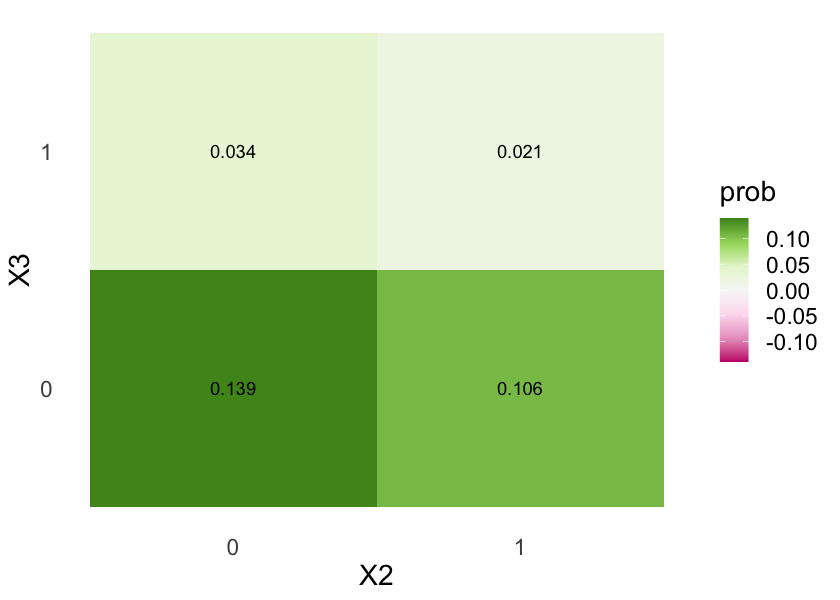

In [83]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = prob)) + 
    geom_text(aes(label = round(prob, 3))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(plot_df$prob)) * c(-1, 1)
                    ) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

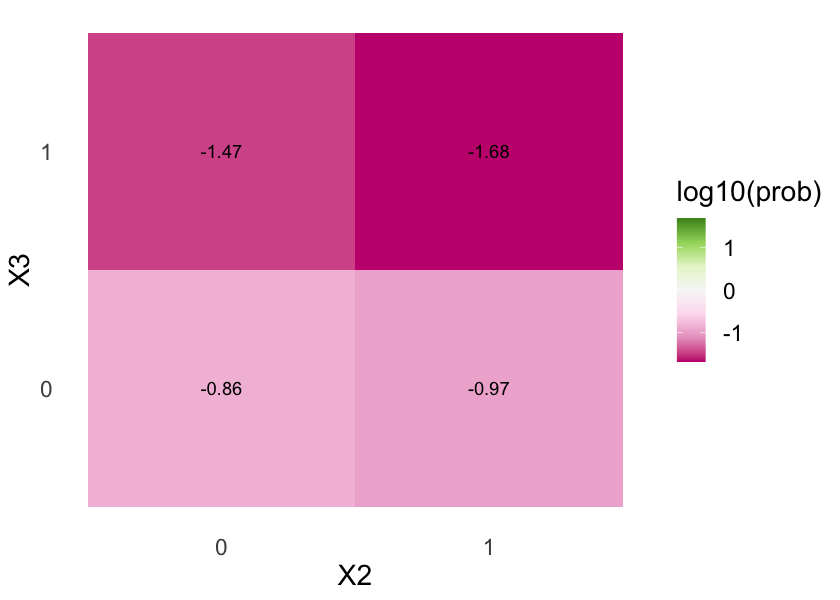

In [84]:
ggplot(plot_df, aes(x=X2, y=X3)) +
    geom_tile(aes(fill = log10(prob))) + 
    geom_text(aes(label = round(log10(prob), 2))) +
    scale_fill_distiller(palette = 'PiYG',direction = 1,
                    limit=max(abs(log10(plot_df$prob))) * c(-1, 1)
                    ) +
theme_minimal() +
 theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))


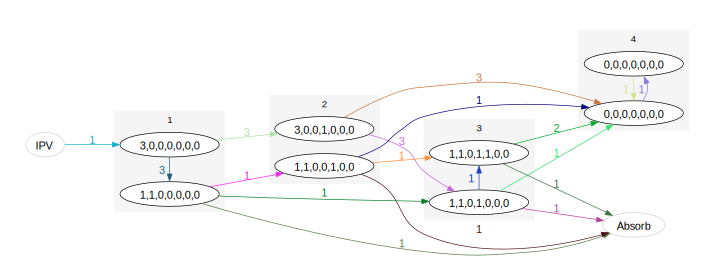

In [362]:

# plot_graph <- function(gam, constrained=TRUE, 
#                        subgraphs=FALSE, ranksep=2, nodesep=1,
#                        subgraphfun=function(state, index) paste(state[-length(state)], collapse=""), 
#                        size=c(6, 6), fontsize=10, rankdir="LR", align=FALSE, nodecolor='white', rainbow=FALSE, penwidth=1) {


#     format_rate <- function(rate) {
#         # tol = .Machine$double.eps^0.5
#         # if (min(abs(c(rate%%1, rate%%1-1))) < tol) {
#         if (rate == round(rate)) {
#             return(rate)
#         } else {
#             return(formatC(rate, format = "e", digits = 2))
#         }
#     }

#     random_color <- function() {
#         if (rainbow) {
#             return(paste("#", paste0(sample(c(0:9, LETTERS[1:6]), 6, T), collapse = ''), sep=''))
#         } else {
#             return('#000000')
#         }
#     }

#     sub_graphs = list()
#     state_classes = list()
    
#     if (constrained) {
#         constrained <- 'true'
#     } else {
#         constrained <- 'false'
#     }

#     states <- c()
#     for (i in 1:(nrow(gam$states))) {
#         states <- c(states, paste0(i, ' [label="', paste(gam$states[i,], collapse = ","), '"];'))
#     }
    
#     edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false,color="COLOR",fontcolor="COLOR"];'

#     subgraph_template <- '
#     subgraph cluster_FREQBIN {
#         rank=same;
#         style=filled;
#         color=whitesmoke;
#         node [style=filled];
#         NODES;
#         label = "FREQBIN";
#     }
#     '
#     start_name <- 'IPV'
#     absorbing_name <- 'Absorb'
#     edges <- c()
#     # IPV edges
#     for (i in 1:length(gam$IPV)) {
#         if (gam$IPV[i] > 0) {
#             edge <- edge_templ
#             edge <- sub('FROM', start_name, edge)
#             edge <- sub('TO', i, edge)
#             edge <- sub('LABEL', gam$IPV[i], edge)
#             edge <- gsub('COLOR', random_color(), edge)                        
#             edges <- c(edges, edge)
#         }
#     }    
#     # Matrix edges
#     for (i in 1:(nrow(gam$states))) {
#         for (j in 1:nrow(gam$states)) {
#             if ((i != j) && (gam$SIM[i, j] > 0)) {
#                 edge <- edge_templ
#                 edge <- sub('FROM', i, edge)
#                 edge <- sub('TO', j, edge)
#                 edge <- sub('LABEL', format_rate(gam$SIM[i, j]), edge)
#                 edge <- gsub('COLOR', random_color(), edge)
#                 edges <- c(edges, edge)
#             }
#         }
#     }

#     absorb_rates <- -rowSums(gam$SIM)
#     for (i in 1:nrow(gam$states)) {

#         # TODO: Avoid the hack below by changing the function to use the graph instead of the matrix
#         if (absorb_rates[i] > abs(1e-14)) {
#         # if (absorb_rates[i] > 0) {
#             edge <- edge_templ
#             edge <- sub('FROM', i, edge)
#             edge <- sub('TO', absorbing_name, edge)
#             edge <- sub('LABEL', absorb_rates[i], edge)
#             edge <- gsub('COLOR', random_color(), edge)            
#             edges <- c(edges, edge)
#         }
#     }

#     graph_spec <- paste(c(states, edges), collapse = '\n')

#     rank_same <- ''

#     if (subgraphs) {        
#         for (i in 1:(nrow(gam$states))) {
#             sg <- subgraphfun(gam$states[i,], index=i)
#             sub_graphs[[sg]] <- c(sub_graphs[[sg]], i)
#         }
#         for (sg in labels(sub_graphs)) {
            
#             nodes <- sub_graphs[[sg]]
#             tmpl <- subgraph_template
#             node_str <- ''
#             for (i in 1:length(nodes)) {
#                 node_str <- paste(node_str, paste('"', nodes[i], '" ', sep=''), sep=' ')
#             }
#             tmpl <- sub('NODES', node_str, tmpl)
#             tmpl <- sub('FREQBIN', sg, tmpl)            
#             tmpl <- sub('FREQBIN', sg, tmpl)            
#             graph_spec <- paste(graph_spec, tmpl)
#         }


#         if (align) {
#             for (i in 1:(nrow(gam$states))) {
#                 sc <- paste(head(gam$states[i,], -1), collapse = ",")
#                 state_classes[[sc]] <- c(state_classes[[sc]], i)
#             }
#             for (sc in labels(state_classes)) {
#                 rank_same <- paste(rank_same, '{rank=same; ', sep='')
#                 nodes <- state_classes[[sc]]
#                 for (i in 1:length(nodes)) {
#                     rank_same <- paste(rank_same, paste('"', nodes[i], '" ', sep=''), sep=' ')
#                 }            
#                 rank_same <- paste(rank_same, ' }', sep='\n')
#             }
#         }
    
#     }

#     style_str <- '
#         graph [compound=true newrank=true pad="0.5", ranksep="RANKSEP", nodesep="NODESEP"] 
#         rankdir=RANKDIR;
#         size="SIZEX,SIZEY";
#         fontname="Helvetica,Arial,sans-serif"
#     	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE, style=filled, fillcolor="NODECOLOR"]
#     	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE, penwidth=PENWIDTH]
#         Absorb [style=filled,color="lightgrey"]
#         IPV [style=filled,color="lightgrey"]
#         RANKSAME
#     '
#     style_str <- sub('SIZEX', size[1], style_str)
#     style_str <- sub('SIZEY', size[2], style_str)
#     style_str <- gsub('FONTSIZE', fontsize, style_str)    
#     style_str <- gsub('RANKDIR', rankdir, style_str)    
#     style_str <- gsub('RANKSAME', rank_same, style_str)
#     style_str <- gsub('RANKSEP', ranksep, style_str)
#     style_str <- gsub('NODESEP', nodesep, style_str)
#     graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
#     graph_string <- gsub('NODECOLOR', nodecolor, graph_string)  
#     graph_string <- gsub('PENWIDTH', penwidth, graph_string)  
#     system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
#     return(display_svg(file="tmp.svg"))
# }
                  
sample_size <- 3
mutation_rate <- 1
max_tons <- 1
total_tons <- Inf
base <- max_tons + 1
graph <- joint_prob_coalescent(sample_size, mutation_rate, max_tons, total_tons=total_tons)

plot_graph(graph_as_matrix(graph), rainbow=TRUE, size=c(10, 8), align=TRUE,
           fontsize=16, ranksep=1, nodesep=0.25,
           subgraphs=TRUE,
           # rankdir="TB",
           subgraphfun=function(state, index) as.character((index+1) %/% 2)
           # subgraphfun=function(state, index) paste(state[-length(state)], collapse="")
)